In [0]:
import pandas as pd

# LIBRARIES FOR THE RNN CLASSIFIER
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer

# FOR THE GOOGLE WORD TO VECTOR WEIGHTS
import gensim

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score

# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',300)

In [0]:
# IMPORTING THE DATASET
train_data=pd.read_csv("./TrainingData.csv")
test_data=pd.read_csv("./SubtaskA_Trial_Test_Labeled.csv")
valid_data=pd.read_csv("./SubtaskA_EvaluationData_labeled.csv")

In [0]:
# FUNCTION TO CLEAN A GIVEN DATASET 
def cleanData(data):
  
  import nltk
  from nltk.corpus import stopwords
  from nltk.stem.porter import PorterStemmer
  nltk.download('stopwords')
  
  # CACHING THE STOP WORDS HELPS IN FASTENING 
  # THE REMOVAL OF THE STOP WORDS
  cachedStopWords = stopwords.words("english")
  
  # REMOVING THE SPECIAL CHARACTERS
  print('Removed Special Characters')
  data=data.str.replace("[^a-zA-Z#]"," ")
  print(data.head())

  # TOKENIZING THE DATASET SENTENCES
  tokenized=data.apply(lambda x: x.split())

  # REMOVING THE STOP WORDS
  print('Removing Stop Words')
  # BY REMOVING THE STOP WORDS FROM NLTK, BUT IT MIGHT
  # REMOVES OTHER IMPORTANT WORDS SUCH AS 'CAN' WHICH MIGHT BE
  # USEFUL FOR SUGGESSTION MINING
  # tokenized = tokenized.apply(
  #   lambda sentence: [word for word in sentence if word not in cachedStopWords]
  # )
  # REMOVING SHORTWORDS (ALMOST ALL ARE STOPWORDS) 
  tokenized = tokenized.apply(
    lambda sentence: [word for word in sentence if len(word)>2 ]
  )
  print(tokenized.head())

  # LOWERING THE SENTENCE CASE SO THAT 'Which' and 'Which' BECOMES THE SAME
  print('Normalizing Sentence Case')
  tokenized = tokenized.apply(
    lambda sentence: [word.lower() for word in sentence]
  )
  print(tokenized.head())

  # CHANGING DIFFERNT WORD FORMS TO ONE
  print('After Stemming')
  stemmer =  PorterStemmer()
  tokenized = tokenized.apply(lambda x: [stemmer.stem(i) for i in x] )
  print(tokenized.head())

  # DETOKENIZING THE TOKENS BACK TO THE SENTENCES
  detokenized= tokenized.apply(lambda x: ' '.join(x))
  return detokenized

In [95]:
# CLEANING THE TRAINING DATA
x_train = cleanData(train_data['sentence'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removed Special Characters
0                   Please enable removing language code from the Dev Center  language history  For example if you ever selected  ru  and  ru ru  laguages and you published this xap to the Store then it causes Tile localization to show the en us default  tile localization which is bad  
1     Note  in your  csproj file  there is a SupportedCultures entry like this   SupportedCultures de DE ru ru RU   SupportedCultures  When I removed the  ru  language code and published my new xap version  the old xap version still remains in the Store with  Replaced and unpublished   
2                                                                                                                                                                                   Wich means the new version not fully replaced the old version and this causes me very serious prob

In [96]:
# CLEANING THE TESTING DATA
x_test = cleanData(test_data['sentence'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removed Special Characters
0                                                                                                                                       I m not asking Microsoft to Gives permission like Android so any app can take my data  but don t keep it restricted like iPhone 
1                                                                                                                                                                                                                                  somewhere between Android and iPhone 
2                                                                                                                                                                                            And in the Windows Store you can flag the App  Requires Trust  for example 
3    Many thanks Sameh Hi  As we know  there is a lot of li

In [97]:
# CLEANING THE VALIDATION DATA
x_valid = cleanData(valid_data['sentence'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removed Special Characters
0                                                                                                                                                        This would enable live traffic aware apps 
1                                                                                                Please try other formatting like bold italics shadow to distinguish titles subtitles from content 
2    Since computers were invented to save time I suggest we be allowed to upload them all in one zip file   using numbering for the file names and the portal could place them in the right order 
3                                                                                                                                               Allow rearranging if the user wants to change them 
4                                                                     

In [98]:
y_train=train_data['label']
y_valid=valid_data['label']
y_test=test_data['label']

# MERGING THE TRAINING AND VALIDATION DATA
# ELSE VALIDATION AND TESTING DATA WILL HAVE DIFFERNET EMBEDDING MATRIX
x_train=x_train.append(x_valid)
y_train=y_train.append(y_valid)

print('train', x_train.shape,y_train.shape)
print('test', x_test.shape,y_test.shape)

train (9333,) (9333,)
test (592,) (592,)


In [99]:
train_data.head()

,id,sentence,label
0,663_3,"""Please enable removing language code from the Dev Center ""language history"" For example if you ever selected ""ru"" and ""ru-ru"" laguages and you published this xap to the Store then it causes Tile localization to show the en-us(default) tile localization which is bad.""",1
1,663_4,"""Note: in your .csproj file, there is a SupportedCultures entry like this: <SupportedCultures>de-DE;ru;ru-RU </SupportedCultures> When I removed the ""ru"" language code and published my new xap version, the old xap version still remains in the Store with ""Replaced and unpublished"".""",0
2,664_1,"""Wich means the new version not fully replaced the old version and this causes me very serious problems: 1.""",0
3,664_2,"""Some of my users will still receive the old xap version of my app.""",0
4,664_3,"""The store randomly gives the old xap or the new xap version of my app.""",0


In [100]:
print(x_test.head())
test_data.head()

0                                                                                     not ask microsoft give permiss like android ani app can take data but don keep restrict like iphon
1                                                                                                                                                     somewher between android and iphon
2                                                                                                                      and the window store you can flag the app requir trust for exampl
3    mani thank sameh know there lot limit due the high secur the itself which veri good but some time need allow some app extra work app which trust hotmail app facebook app skype app
4                                                                              the idea that can develop regular app and request our permiss the manifest the app can ask for trust more
Name: sentence, dtype: object


,id,sentence,label
0,1310_1,"I'm not asking Microsoft to Gives permission like Android so any app can take my data, but don't keep it restricted like iPhone.",1
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App [Requires Trust] for example.,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a lot of limitations is WP8 OS due the high security in the OS itself which is very good, but some time we need to allow some apps to do extra works, apps which we trust i.e: hotmail app, facebook app, skype app ....",0
4,1313_3,"The idea is that we can develop a regular app and we request our permissions in the manifest, OR the app can ASK FOR TRUST_�_ more",1


In [208]:
# BUILDING VOCABULARY FROM THE SENTENCES
# THIS WILL HELP IN GETTING THE INPUT SEQUENCES FOR THE 
mxlen=0
tokenized=x_train.apply(lambda x: x.split())
for tokens in tokenized:
  mxlen=max(mxlen,len(tokens))
print('MAX LEN', mxlen)

MAX LEN 184
VOCAB SIZE 6493


In [0]:
all_words= [ word for tokens in tokenized for word in tokens]
vocab = sorted(list(set(all_words)))
vocab_train_len=len(vocab)

print('VOCAB SIZE',len(vocab))

In [0]:
MXSEQLEN=80
EMBEDDING_DIM = 300

In [213]:
# BUILDING TOKENIZER FROM THE TRAINING DATA
# SAME TOKENIZER WILL BE USED IN THE TESTING AND VALIDATIONS
tokenizer = Tokenizer(num_words=vocab_train_len, lower=True, char_level=False)
tokenizer.fit_on_texts(x_train.tolist())
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 6483 unique tokens.


In [214]:
# form the sequences that will be the input to the network
# padd or remove values to make sequences of equal length
train_sequence = tokenizer.texts_to_sequences(x_train.tolist())
train_sequence = sequence.pad_sequences(train_sequence, maxlen=MXSEQLEN)
print(train_sequence)

[[   0    0    0 ...  250   34  502]
 [   0    0    0 ...  614    2 1917]
 [   0    0    0 ...   89  978   93]
 ...
 [   0    0    0 ...   89   89  904]
 [   0    0    0 ...  490   71   91]
 [   0    0    0 ...   63  210  190]]


In [217]:
# TEST SEQUENCE BUILT FROM THE SAME TRAINING VOCABULARY
test_sequence = tokenizer.texts_to_sequences(x_test.tolist())
test_sequence = sequence.pad_sequences(test_sequence, maxlen=MXSEQLEN)
print(test_sequence)

[[  0   0   0 ... 644  16 665]
 [  0   0   0 ... 152   2 665]
 [  0   0   0 ... 850   4  90]
 ...
 [  0   0   0 ... 339   4 206]
 [  0   0   0 ...   1 310 215]
 [  0   0   0 ... 193   1 415]]


In [0]:
# DOWNLOADING THE PRETRAINED GOOGLE NEWS WORD TO VECTOR REPRESENTATIONS
!wget -P /content/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d /content/GoogleNews-vectors-negative300.bin.gz 

--2020-03-24 20:05:48--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/content/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  84.9MB/s    in 17s     

2020-03-24 20:06:05 (93.0 MB/s) - ‘/content/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [123]:
# LOADING WORD TO VECTOR
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [219]:
# BUILDING THE EMBEDDING WEIGHT MATRIX
train_embedding_weights = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))

for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print(train_embedding_weights.shape)

(6484, 300)


In [0]:
# OUR RNN MODEL
def RNN(embedding_weights,num_words):
    
    # THE INPUT SEQUENCE DIMENSION/ INPUT TO THE RNN
    sequence_input      =   Input(shape=(MXSEQLEN,), dtype='int32')
    
    # FIRST LAYER WILL BE THE OF EMBEDDING_WEIGHTS     
    embedding_layer = Embedding(
        num_words,
        EMBEDDING_DIM,
        weights=[embedding_weights],
        input_length=MXSEQLEN,
        trainable=False
    )
    
    # THE NEXT SEQUENCES 
    embedded_sequences  =   embedding_layer(sequence_input)

    lstm_layer = LSTM(256)(embedded_sequences)                    # ADDING ONE LSTM LAYER OF 256 NEURONS
    next_layer = Dense(128, activation='relu')(lstm_layer)        # DENSE NEURON LAYER
    next_layer = Dropout(0.5)(next_layer)                         # FEW DROPOUTS FOR AVOIDING OVERFIT
    preds = Dense(1, activation='sigmoid')(next_layer)  # FINAL DENSE LAYER
    
    model = Model(sequence_input, preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    
    model.summary()
    return model

In [221]:
rnn_model = RNN(train_embedding_weights, len(train_word_index)+1) 

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 80, 300)           1945200   
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 2,548,593
Trainable params: 603,393
Non-trainable params: 1,945,200
___________________________________________

In [222]:
# CONFIGURING AND TRAINING THE MODEL
EPOCHS = 2
BATCH_SIZE = 50
history = rnn_model.fit(
    train_sequence, 
    y_train, 
    epochs=EPOCHS, 
    validation_split=0.1, 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Train on 8399 samples, validate on 934 samples
Epoch 1/2
8399/8399 [==============================] - 136s 16ms/sample - loss: 0.5518 - acc: 0.7550 - val_loss: 0.3630 - val_acc: 0.8769
Epoch 2/2
8399/8399 [==============================] - 135s 16ms/sample - loss: 0.4129 - acc: 0.8157 - val_loss: 0.2574 - val_acc: 0.8961


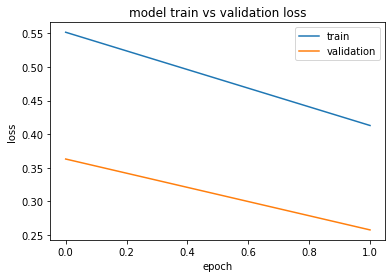

In [223]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
predict=rnn_model.predict(test_sequence)

In [0]:
rnn_model.save('/content/rnn_model.h5')

In [186]:
from tensorflow.keras.models import load_model
loaded_model=load_model('rnn_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
predict=[int(x+0.5) for x in predict]

In [227]:
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

F1 Score: 65.88%
Accuracy: 70.78%


In [230]:
test_data['label']=y_test
test_data.head()

,id,sentence,label
0,1310_1,"I'm not asking Microsoft to Gives permission like Android so any app can take my data, but don't keep it restricted like iPhone.",1
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App [Requires Trust] for example.,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a lot of limitations is WP8 OS due the high security in the OS itself which is very good, but some time we need to allow some apps to do extra works, apps which we trust i.e: hotmail app, facebook app, skype app ....",0
4,1313_3,"The idea is that we can develop a regular app and we request our permissions in the manifest, OR the app can ASK FOR TRUST_�_ more",1


In [231]:
test_data['label']=predict
test_data.head()

,id,sentence,label
0,1310_1,"I'm not asking Microsoft to Gives permission like Android so any app can take my data, but don't keep it restricted like iPhone.",1
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App [Requires Trust] for example.,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a lot of limitations is WP8 OS due the high security in the OS itself which is very good, but some time we need to allow some apps to do extra works, apps which we trust i.e: hotmail app, facebook app, skype app ....",1
4,1313_3,"The idea is that we can develop a regular app and we request our permissions in the manifest, OR the app can ASK FOR TRUST_�_ more",0
